# Plotting for final paper

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats
sns.set_style('ticks')
sns.set_context('paper')
import duckdb as ddb

## Quad plot

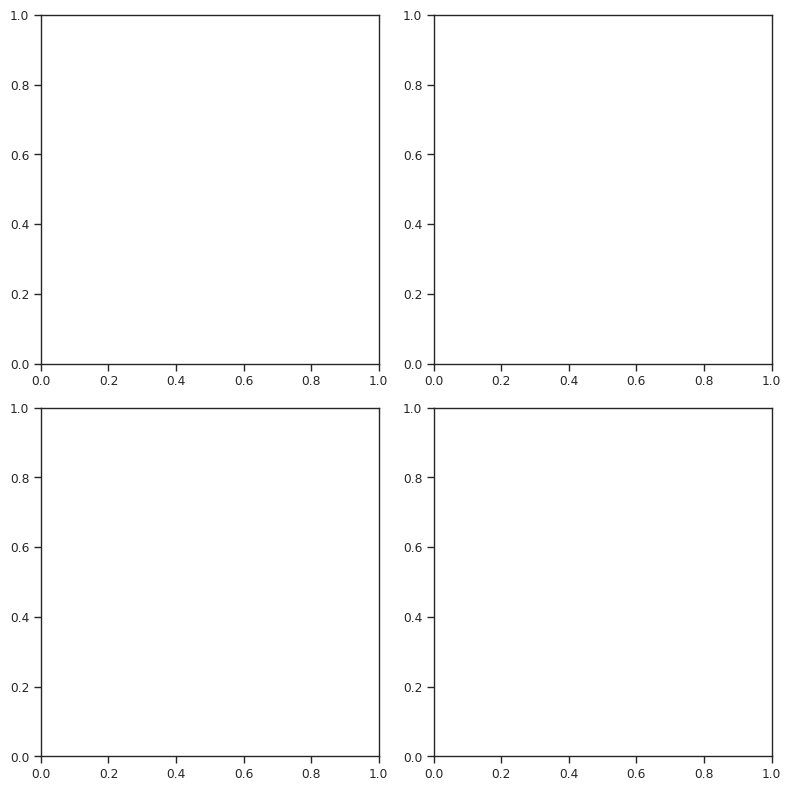

In [2]:
fig_quad, ax_quad = plt.subplots(2,2, figsize=(8,8))
fig_quad.tight_layout()

### FATCAT Pvalue comaprison

In [3]:
# get hait data
hait_data = pd.read_csv('../data/validation/structure/hait_fatcat.csv', index_col=0)

In [4]:
hait_data['exp p'] = np.exp(hait_data['p_value'])
hait_data['pass'] = hait_data['p_value'] < 0.001

In [5]:
import statsmodels.stats.proportion

In [6]:
hait_low, hait_high = statsmodels.stats.proportion.proportion_confint(hait_data['pass'].sum(), len(hait_data), method='binom_test', alpha=0.001)

In [7]:
print(f"CI For hait: {(hait_low, hait_high)}")

CI For hait: (0.9820211734983686, 0.9972160474176245)


In [8]:
# get data
l2t_data = pd.read_csv('../data/validation/structure/l2t_sample_fatcat.csv')

In [9]:
l2t_data = l2t_data.rename(columns={'(query_align_cov+subject_align_cov)/2.0': 'coverage'})
l2t_data['pass'] = l2t_data['p_value'] < 0.001

In [10]:
# bin l2t by coverage
bins = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
l2t_data['Coverage bin'] = pd.cut(l2t_data['coverage'], bins=[0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

In [11]:
low_cov_data = l2t_data[l2t_data['coverage'] <=0.8]
_ = statsmodels.stats.proportion.proportion_confint(low_cov_data['pass'].sum(), len(low_cov_data), method='binom_test', alpha=0.001)
print(f"CI for ourt data with coverage between 0.75 and 0.80: {_}")

CI for ourt data with coverage between 0.75 and 0.80: (0.9932776260888795, 0.9999751836807147)


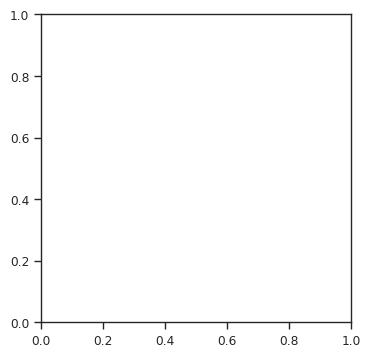

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

def fatcat_plot(ax):
    g = sns.ecdfplot(data=l2t_data, x='p_value', hue='Coverage bin',ax=ax, palette='crest', lw=2)
    sns.ecdfplot(data=hait_data['p_value'].values, color='orange', label='Hait et al.', ax=ax, lw=2)
    ax.set_xscale('log')
    labels = list(l2t_data['Coverage bin'].dropna().unique())
    labels.reverse()
    labels = labels + ['Hait et al.']
    ax.legend(labels=labels, title='BLAST Coverage', loc='lower right')
    ax.set_xlabel('FATCAT P-value')
    ax.set_ylabel('Cummulative proportion')
fatcat_plot(ax_quad[1,1])

### Blast alignment comparison

In [13]:
import duckdb as ddb

In [14]:
# load hait alignment data
hait_data = pd.read_csv('../data/validation/hait_aligned_scores.csv', index_col=0)

In [15]:
# connect to out database
con = ddb.connect(database='../data/database.ddb', read_only=True)

In [16]:
our_nbs = con.execute(f"SELECT (2 * bit_score::FLOAT/(query_align_len::FLOAT + subject_align_len::FLOAT))::FLOAT FROM pairs").df().iloc[:,0].values
our_nbs95 = con.execute(f"SELECT (2 * bit_score::FLOAT/(query_align_len::FLOAT + subject_align_len::FLOAT))::FLOAT FROM pairs WHERE (query_align_cov + subject_align_cov)/2.0 > 0.95").df().iloc[:,0].values

In [17]:
our_pid = con.execute(f"SELECT scaled_local_symmetric_percent_id FROM pairs").df().iloc[:,0].values
our_pid95 = con.execute(f"SELECT scaled_local_symmetric_percent_id FROM pairs WHERE (query_align_cov + subject_align_cov)/2.0 > 0.95").df().iloc[:,0].values

In [18]:
hait_data['nbs'] = hait_data.apply(lambda row: 2 * row['bit_score'] / (row['query_align_len'] + row['subject_align_len']), axis=1)

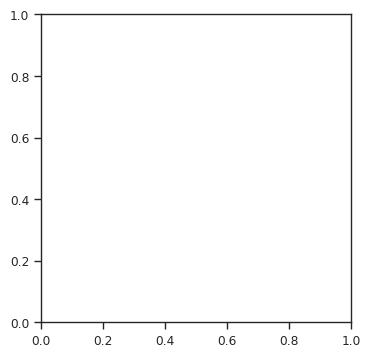

In [20]:
# add aggregate dataframe so that we can plot it
def plot_nbs(ax):
    df2_ = pd.DataFrame({'nbs': hait_data['nbs'].values, 'source': 'Hait et al.'})
    df1_ = pd.DataFrame({'nbs': our_nbs, 'source': 'learn2therm'})
    df = pd.concat([df1_, df2_], axis=0, ignore_index=True) 
    # plot
    
    sns.histplot(data=df, x='nbs', bins=25, hue='source', ax=ax, stat='probability', common_norm=False, common_bins=True, element='step')
    ax.set_xlabel("Normalized bit score")
    ax.set_ylabel('Probability')
fig, ax = plt.subplots(figsize=(4,4))
plot_nbs(ax_quad[0,0])

In [21]:
scipy.stats.ttest_ind(our_nbs, hait_data['nbs'].values, nan_policy='omit', alternative='greater')

Ttest_indResult(statistic=5.496374587751134, pvalue=1.9383996979827688e-08)

In [22]:
scipy.stats.ttest_ind(our_nbs95, hait_data['nbs'].values, nan_policy='omit', alternative='greater')

Ttest_indResult(statistic=22.939194417222144, pvalue=9.472012870440822e-117)

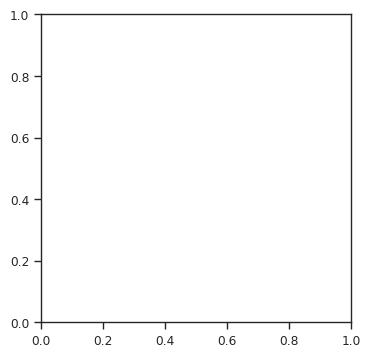

In [23]:
# add aggregate dataframe so that we can plot it
def plot_pid(ax):
    df2_ = pd.DataFrame({'scaled_local_symmetric_percent_id': hait_data['scaled_local_symmetric_percent_id'].values, 'source': 'Hait et al.'})
    df1_ = pd.DataFrame({'scaled_local_symmetric_percent_id': our_pid, 'source': 'learn2therm'})
    df = pd.concat([df1_, df2_], axis=0, ignore_index=True) 
    # plot
    
    sns.histplot(data=df, x='scaled_local_symmetric_percent_id', bins=25, hue='source', ax=ax, stat='probability', common_norm=False, common_bins=True, element='step')
    ax.set_xlabel("Symmetric %id")
    ax.set_ylabel('Probability')
fig, ax = plt.subplots(figsize=(4,4))
plot_pid(ax_quad[0,1])

In [22]:
scipy.stats.ttest_ind(our_pid, hait_data['scaled_local_symmetric_percent_id'].values, nan_policy='omit', alternative='greater')

Ttest_indResult(statistic=4.637955568485574, pvalue=1.759365209727622e-06)

In [24]:
scipy.stats.ttest_ind(our_pid95, hait_data['scaled_local_symmetric_percent_id'].values, nan_policy='omit', alternative='greater')

Ttest_indResult(statistic=26.491742863139663, pvalue=6.064190349532674e-155)

In [25]:
con.close()

### HMMER compare

In [26]:
# get l2t data
con = ddb.connect('../data/database.ddb', read_only=True)
con.execute("CREATE OR REPLACE TEMP TABLE labels AS SELECT * FROM read_parquet('../data/validation/hmmer/hmmer_labels/*.parquet')")

l2t_data = con.execute("""SELECT (pairs.query_align_cov+pairs.subject_align_cov)/2.0, labels.score, labels.bool_confirmed
    FROM pairs INNER JOIN labels ON pairs.meso_pid=labels.meso_pid AND pairs.thermo_pid=labels.thermo_pid
""").df().rename(
    columns={'score': 'jaccard_score', 'bool_confirmed': 'functional', '((pairs.query_align_cov + pairs.subject_align_cov) / 2.0)': 'coverage'})

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [27]:
l2t_data

,coverage,jaccard_score,functional
0,0.868671,1.000000,True
1,0.867114,1.000000,True
2,0.933825,1.000000,True
3,0.919516,0.333333,False
4,0.874820,1.000000,True
...,...,...,...
68825729,0.996855,1.000000,True
68825730,0.837541,1.000000,True
68825731,0.904905,1.000000,True
68825732,0.939367,0.666667,False


In [28]:
con.execute("SELECT COUNT(*) FROM pairs INNER JOIN labels ON (pairs.meso_pid=labels.meso_pid AND pairs.thermo_pid=labels.thermo_pid)").df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,count_star()
0,68825734


In [29]:
con.execute("SELECT COUNT(*) FROM pairs").df()

,count_star()
0,68825734


In [30]:
# get hait data
hait_data = pd.read_csv('../data/validation/hmmer/hait_scores.csv', index_col=0)[['jaccard_score', 'functional']]

# compute a t statistic
t, p = scipy.stats.ttest_ind(l2t_data['jaccard_score'], hait_data['jaccard_score'], alternative='greater',equal_var=False, nan_policy='omit')
print(f"t, p: {t}, {p} full")
t, p = scipy.stats.ttest_ind(l2t_data[l2t_data['coverage']>0.95]['jaccard_score'], hait_data['jaccard_score'], alternative='greater',equal_var=False, nan_policy='omit')
print(f"t, p: {t}, {p} 95+")



t, p: -7.57380226332593, 0.99999999999997 full
t, p: 7.247534697838242, 3.240659033057837e-13 95+


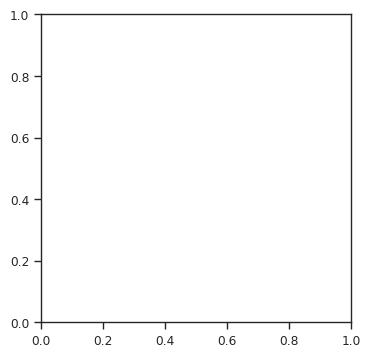

In [31]:
def plot_hmmer(ax):
    bins = list(np.linspace(0, 1, 10))
    bins.append(1.0)
    ax.hist(
        [l2t_data['jaccard_score'], l2t_data[l2t_data['coverage']>0.95]['jaccard_score'], hait_data['jaccard_score']],
        bins=10,
        alpha=1.0, 
        label=[f'learn2therm N={len(l2t_data)}',f'learn2therm 95+ N={int((l2t_data["coverage"]>0.95).sum())}', f'Hait et al. N={len(hait_data)}'],
        color=['C0', 'C2', 'C1'],
        density=True)
    ax.set_xlabel('Jaccard score of Pfam annotations')
    ax.set_ylabel('Density')
    ax.legend()
fig, ax = plt.subplots(figsize=(4,4))
plot_hmmer(ax_quad[1,0])

### save end result

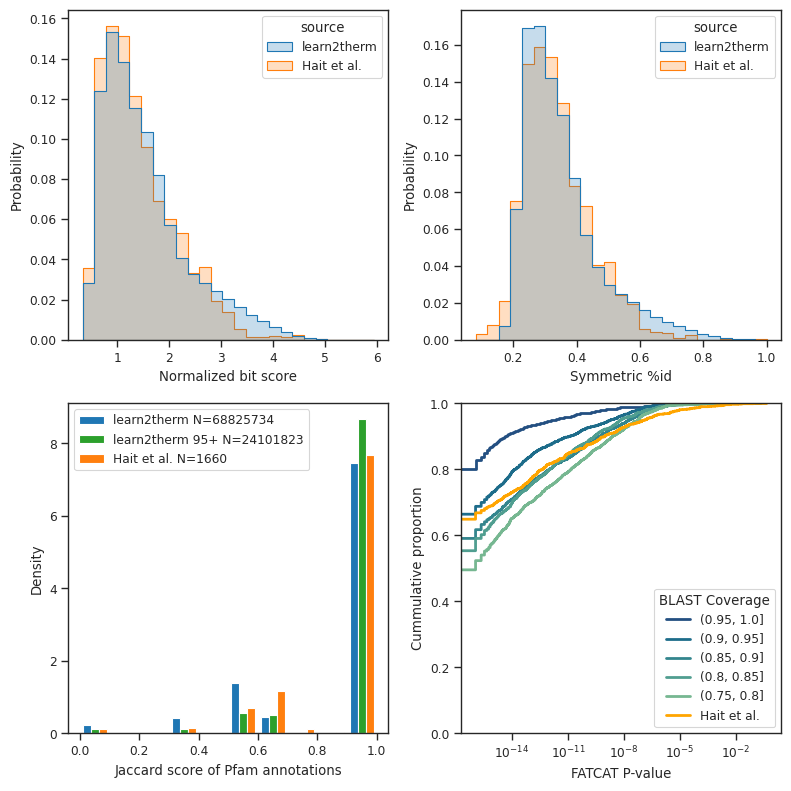

In [32]:
fig_quad.tight_layout()
fig_quad

In [33]:
fig_quad.savefig('./quad_validation.png', dpi=400, bbox_inches='tight')

## TM vs OGT plot

In [34]:
data = pd.read_csv('../data/validation/tm/ogt_vs_tm.csv', index_col=0)

In [35]:
data

,OGT,Tm,from
0,29.000000,53.124645,meltome
1,30.666666,56.693844,meltome
2,30.000000,43.373369,meltome
3,30.666666,40.693719,meltome
4,30.666666,48.069618,meltome
...,...,...,...
4635,71.000000,90.700000,fireprot
4636,75.000000,69.500000,fireprot
4637,35.000000,53.000000,fireprot
4638,32.333332,78.700000,fireprot


In [36]:
min_ = data[['OGT', 'Tm']].min().min()
max_ = data[['OGT', 'Tm']].max().max()

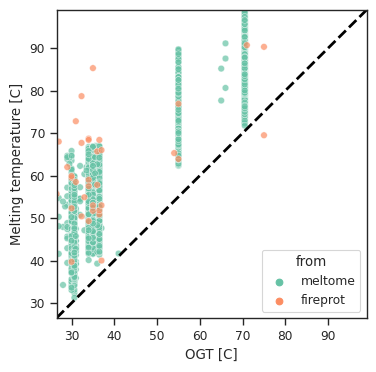

In [37]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data, x='OGT', y='Tm', alpha=0.7, hue='from', palette='Set2', ax=ax)
ax.set_xlim(min_, max_)
ax.set_ylim(min_, max_)
ax.plot([min_, max_], [min_, max_], c='k', lw=2, ls='--')
ax.set_xlabel('OGT [C]')
ax.set_ylabel('Melting temperature [C]')
fig.savefig('./tm.png', dpi=400, bbox_inches='tight')

In [38]:
scipy.stats.spearmanr(data['OGT'].values, data["Tm"].values)

SignificanceResult(statistic=0.8492773232574822, pvalue=0.0)

In [39]:
data['pass'] = data['Tm'] > data['OGT']

In [40]:
scipy.stats.binomtest(sum(data['pass'].values), len(data), p=0.99, alternative='greater')

BinomTestResult(k=4639, n=4640, alternative='greater', statistic=0.9997844827586206, pvalue=2.67518885665121e-19)

## delta OGT plot

In [41]:
import duckdb as ddb

In [42]:
con = ddb.connect('../data/database.ddb', read_only=True)

### proeins

In [43]:
ogt_diff_effect = con.execute("""SELECT m_taxa.temperature AS meso_ogt,
                          t_taxa.temperature AS thermo_ogt,
                          thermo_ogt - meso_ogt AS ogt_diff
                          FROM pairs
                          JOIN taxa AS m_taxa ON (pairs.meso_taxid = m_taxa.taxid)
                          JOIN taxa AS t_taxa ON (pairs.thermo_taxid = t_taxa.taxid)
                          """).df()

In [44]:
len(ogt_diff_effect)

68825734

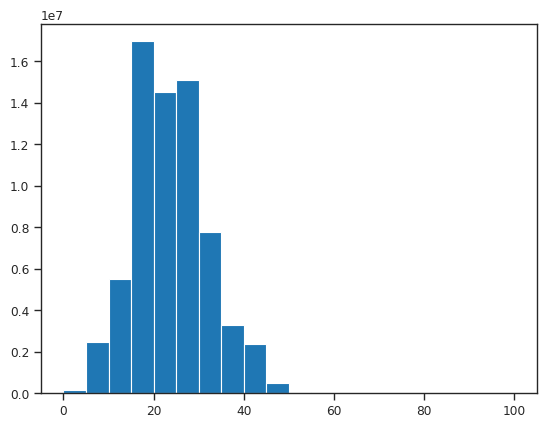

In [45]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80, 85, 90, 95, 100]
n, bins, _ = plt.hist(ogt_diff_effect['ogt_diff'], bins = bins)

data = {'Bins':bins[:-1], 'Counts':n}

In [46]:
ogt_diff_prot = pd.DataFrame(data)

In [47]:
remaining = []
max_diff = 80

for i in range(max_diff):
    remaining.append(np.sum(ogt_diff_effect['ogt_diff'] >= i))
    
remaining_pct = [i/len(ogt_diff_effect['ogt_diff']) for i in remaining]

rem = {'dT':range(max_diff), 'remaining':remaining, 'pct':remaining_pct}

remaining_df = pd.DataFrame(rem)

### taxa

In [48]:
ogt_diff_effect_taxa = con.execute("""SELECT m_taxa.temperature AS meso_ogt,
                          t_taxa.temperature AS thermo_ogt,
                          thermo_ogt - meso_ogt AS ogt_diff
                          FROM taxa_pairs
                          JOIN taxa AS m_taxa ON (taxa_pairs.meso_taxid = m_taxa.taxid)
                          JOIN taxa AS t_taxa ON (taxa_pairs.thermo_taxid = t_taxa.taxid)
                          WHERE taxa_pairs.is_pair
                          """).df()

In [49]:
ogt_diff_effect_taxa

,meso_ogt,thermo_ogt,ogt_diff
0,37.0,60.0,23.0
1,36.0,60.0,24.0
2,37.0,60.0,23.0
3,29.0,60.0,31.0
4,29.0,60.0,31.0
...,...,...,...
146887,28.0,45.0,17.0
146888,30.0,47.5,17.5
146889,28.0,47.5,19.5
146890,34.0,45.0,11.0


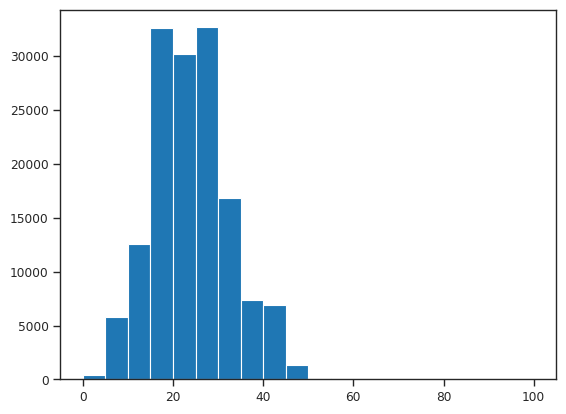

In [50]:
n, bins, _ = plt.hist(ogt_diff_effect_taxa['ogt_diff'], bins = bins)
data = {'Bins':bins[:-1], 'Counts':n}
ogt_diff_taxa = pd.DataFrame(data)

In [51]:
pairs_remaining=remaining_df
delta_hist=ogt_diff_taxa

In [52]:
pairs_remaining['dT'] = pairs_remaining['dT'].astype(float)

In [53]:
delta_hist['Bins'] = delta_hist['Bins'].astype(int)

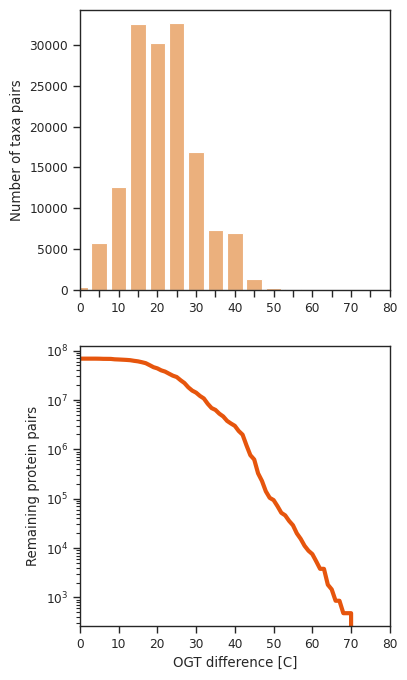

In [54]:
fig, ax = plt.subplots(2,1, figsize=(4,8))
sns.barplot(data=delta_hist, x='Bins', y='Counts', ax=ax[0], color='#fdae6b')
ax[0].set_ylabel('Number of taxa pairs')
ax[0].set_xlabel(None)
ax[0].set_xlim(0.0, 16)
for i, label in enumerate(ax[0].get_xticklabels()):
    if i % 2 == 0:
        continue
    label.set_visible(False)
# for i, label in enumerate(ax[0].get_xticks()):
#     if i % 2 == 0:
#         continue
#     label.set_visible(False)



sns.lineplot(data=pairs_remaining, x='dT', y='remaining', ax=ax[1], lw=3, c='#e6550d')
ax[1].set_yscale('log')
ax[1].set_ylabel('Remaining protein pairs')
ax[1].set_xlabel('OGT difference [C]')
ax[1].set_xlim(0.0, 80)
fig.savefig('./dogt.png', dpi=400, bbox_inches='tight')